# saving growth model 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from macrohet import visualise
from tqdm.auto import tqdm
import os
import warnings
from matplotlib.lines import Line2D

warnings.simplefilter(action='ignore', category=FutureWarning)

# Conversion factor
meters_per_pixel = 1.4949402023919043E-07  # Micrometers per pixel
micrometers_per_pixel = meters_per_pixel*1E6 # Micrometers per pixel

# set display params
sns.set(style = 'white')

# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Nimbus Sans'
# import matplotlib as mpl
# mpl.rcdefaults()
# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors
sns.set_palette(expanded_piyg)

In [2]:
output_dir = '/mnt/SYNO/macrohet_syno/results/manuscript/uptake_vs_transfer'#/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480/'#'/Users/dayn/data/macrohet_mac/temp_results/'#
os.makedirs(output_dir, exist_ok = True)

In [2]:
base_dir = f'/mnt/SYNO/macrohet_syno/'

In [3]:
sc_df_fn = os.path.join(base_dir, 'results/dfs/ND4_sc_df.pkl')

In [4]:
df = pd.read_pickle(sc_df_fn)

In [10]:
df.to_pickle(sc_df_fn)

In [6]:
df.keys()

Index(['Time (hours)', 'Mtb Area (µm)', 'dMtb Area (µm)', 'Mphi Area (µm)',
       'dMphi Area (µm)', 'Infection Status', 'Initial Infection Status',
       'Final Infection Status', 'x', 'y', 'GFP', 'RFP', 'Eccentricity', 'MSD',
       'Technical Replicate', 'Biological Replicate', 'Strain', 'Compound',
       'Concentration', 'Cell ID', 'Acquisition ID', 'Experiment ID',
       'Unique ID', 'ID'],
      dtype='object')

In [138]:
# Iterate over each unique ID in the DataFrame
for ID in tqdm(df['ID'].unique()):
    # Filter the DataFrame for the current ID
    sc_df = df[df['ID'] == ID].copy()
    
    # Determine the window size based on the ID
    window = 5 if 'PS0000' in ID else 10
    
    # Extract time points and bacterial population values
    time_points = sc_df['Time (hours)'].values
    bacterial_population = sc_df['Mtb Area Processed (µm)'].values
    
    # Fit the population model using LOWESS
    model = sm.nonparametric.lowess(endog=bacterial_population, exog=time_points, frac=0.25)
    time_model = model[:, 0] -(window / 2) + 0.5 ## shifting the time model back to account for the shift from rolling average
    population_model = np.clip(model[:, 1], 0, None) # clipping any population models above 0

    if len(sc_df) < len(population_model):
        print('trouble with', ID)
        break
    # Padding population_model with NaNs if it is shorter than sc_df
    if len(sc_df) > len(population_model):
        length_diff = len(sc_df) - len(population_model)
        pad_front = length_diff // 2
        pad_end = length_diff - pad_front
        
        population_model = np.concatenate([
            np.full(pad_front, np.nan),
            population_model,
            np.full(pad_end, np.nan)
        ])
        
        time_model = np.concatenate([
            np.full(pad_front, np.nan),
            time_model,
            np.full(pad_end, np.nan)
        ])

    # Add the new columns to the original DataFrame for this specific ID
    df.loc[df['ID'] == ID, 'Time Model (hours)'] = time_model
    df.loc[df['ID'] == ID, 'Mtb Area Model (µm)'] = population_model

    # min_mtb = sc_df['Mtb Area Model (µm)'].min()
    # min_mtb_time = sc_df.loc[sc_df['Mtb Area Model (µm)'].idxmin(), 'Time (hours)']
    
    # max_mtb = sc_df['Mtb Area Model (µm)'].max()
    # max_mtb_time = sc_df.loc[sc_df['Mtb Area Model (µm)'].idxmax(), 'Time (hours)']
    
    # delta_mtb = max_mtb - min_mtb
    
    # if max_mtb_time < min_mtb_time:
    #     delta_mtb = -delta_mtb
    #     print(ID, delta_mtb)

    # # Assign delta_mtb to a new column 'dMtb Area (µm)' for the specific ID
    # df.loc[df['ID'] == ID, 'dMtb Area (µm)'] = delta_mtb

  0%|          | 0/13405 [00:00<?, ?it/s]

In [139]:
df.to_pickle(os.path.join(base_dir, 'results/dfs/sc_model_df.pkl'))

In [140]:
print()

# Better measure of dMtb

At the moment, dMtb is simply the last minus the first observation. i need to make sure it is the average of the first N non zero observations

In [94]:
# Iterate over each unique ID in the DataFrame
for ID in tqdm(df['ID'].unique()):
    # Filter the DataFrame for the current ID
    sc_df = df[df['ID'] == ID]
    
    min_mtb = sc_df['Mtb Area Model (µm)'].min()
    min_mtb_time = sc_df.loc[sc_df['Mtb Area Model (µm)'].idxmin(), 'Time (hours)']
    
    max_mtb = sc_df['Mtb Area Model (µm)'].max()
    max_mtb_time = sc_df.loc[sc_df['Mtb Area Model (µm)'].idxmax(), 'Time (hours)']

    
    delta_mtb = max_mtb - min_mtb

    if max_mtb_time < min_mtb_time:
        delta_mtb = -delta_mtb
        print(min_mtb_time, max_mtb_time)

  0%|          | 0/13405 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
sc_df

In [85]:
IDs = df['ID'].unique()

In [90]:
ID = '1796.6.12.ND0003'

In [335]:
sc_df = df[df['ID'] == '1796.6.12.ND0003']
# Extract time points and bacterial population values
time_points = sc_df['Time (hours)'].values
bacterial_population = sc_df['Mtb Area Processed (µm)'].values

# Fit the population model using LOWESS
model = sm.nonparametric.lowess(endog=bacterial_population, exog=time_points, frac=0.35)
time_model = model[:, 0]
population_model = model[:, 1]

Text(0.5, 1.0, 'Cell ID: 1796.6.12.ND0003 Mtb growth models with varying degrees of smoothing')

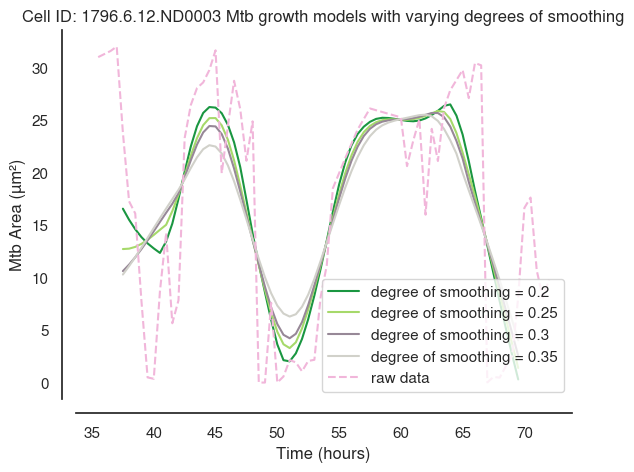

In [91]:
# ID = IDs[9878]
sc_df = df[df['ID'] == ID]
# Extract time points and bacterial population values
time_points = sc_df['Time (hours)'].values
bacterial_population = sc_df['Mtb Area Processed (µm)'].values

for frac in [0.2, 0.25, 0.3, 0.35]:
    # Fit the population model using LOWESS
    model = sm.nonparametric.lowess(endog=bacterial_population, exog=time_points, frac=frac)
    time_model = model[:, 0] - window/2
    population_model = model[:, 1]
    sns.lineplot(y = population_model, x = time_model, label = f'degree of smoothing = {frac}')

sns.lineplot(y = sc_df['Mtb Area (µm)'].values, x = sc_df['Time (hours)'].values, label = 'raw data', ls='dashed')
# sns.lineplot(y = sc_df['Mtb Area Processed (µm)'].values, x = sc_df['Time (hours)'].values, label = 'cleaned data')
sns.despine(offset=10)
plt.xlabel('Time (hours)')
plt.ylabel('Mtb Area (µm²)')
# plt.hlines(y = [min_detectable_mtb, max_detectable_mtb], xmin = 0, xmax = 74, colors=expanded_piyg[-1])
title = f'Cell ID: {ID} Mtb growth models with varying degrees of smoothing'
plt.title(title)
# plt.savefig('/mnt/SYNO/macrohet_syno/results/multi_traj_plot/varying_degrees_smoothing_2.pdf', bbox_inches='tight', dpi=314)

In [372]:
min_detectable_mtb = sc_df['Mtb Area Processed (µm)'].loc[lambda x: x > 1.92].iloc[0]

In [373]:
max_detectable_mtb = sc_df['Mtb Area Processed (µm)'].max()

In [374]:
delta_mtb = max_detectable_mtb - min_detectable_mtb
delta_mtb

5.073100893811532

In [350]:
import statsmodels.api as sm

In [359]:
sc_df = df[df['ID'] == '426.3.4.PS0000']

time_points = sc_df['Time (hours)'].values
# isolate and interpolate the population values to remove NaN values 
bacterial_population = sc_df['Mtb Area (µm)'].interpolate(method='linear').interpolate(method='backfill').rolling(window=window).median().values

# fit a population model to the growth
model = sm.nonparametric.lowess(exog=time_points, endog=bacterial_population, frac=0.35)
time_model = model[:,0]
population_model = model[:,1]


In [364]:
population_model.max()-population_model[population_model>0].min()

7.0413668310815325

In [365]:
population_model[population_model>0].min()

0.06025766347659816

In [371]:
min_detectable_mtb

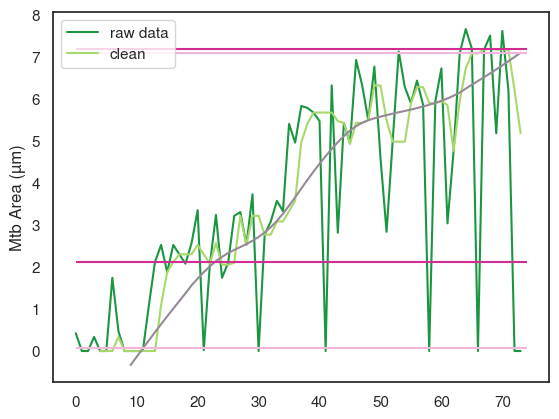

In [378]:


sns.lineplot(df[df['ID'] == '426.3.4.PS0000']['Mtb Area (µm)'], label = 'raw data')
# sns.lineplot(sc_df[sc_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)'], label = 'non zero')
sns.lineplot(y = sc_dt_df['Mtb Area Processed (µm)'], x =time_points , label = 'clean')
sns.lineplot(y = population_model, x = time_model)
plt.hlines(y = [min_detectable_mtb, max_detectable_mtb], xmin = 0, xmax = 74, colors=expanded_piyg[-1], label = 'non growth')
plt.hlines(y = [population_model[population_model>0].min(), population_model.max()], xmin = 0, xmax = 74, colors=expanded_piyg[-2], label = 'growth model')

# Need to change this to have a negative sign

In [328]:
# Initialize an empty list to store the results
results = []

# Group the DataFrame by 'ID'
for id_value, group in df.groupby('ID'):
    # Calculate min_detectable_mtb
    try:
        min_detectable_mtb = group['Mtb Area Processed (µm)'].loc[lambda x: x > 1.92].iloc[0]
        min_mtb_time = group.loc[group['Mtb Area Processed (µm)'].loc[lambda x: x > 1.92].index[0], 'Time (hours)']
    except IndexError:
        min_detectable_mtb = None
        min_mtb_time = None  # Handle cases where no value is above 1.92
        
    # Calculate max_detectable_mtb
    max_detectable_mtb = group['Mtb Area Processed (µm)'].max() if not group['Mtb Area Processed (µm)'].loc[lambda x: x > 1.92].empty else None
    max_mtb_time = group.loc[group['Mtb Area Processed (µm)'].idxmax(), 'Time (hours)'] if max_detectable_mtb is not None else None

    # Calculate delta_mtb with sign consideration based on Time (hours)
    if min_detectable_mtb is not None and max_detectable_mtb is not None:
        delta_mtb = max_detectable_mtb - min_detectable_mtb
        if max_mtb_time is not None and min_mtb_time is not None and max_mtb_time < min_mtb_time:
            delta_mtb = -delta_mtb  # Make delta negative if max occurs before min in time

    else:
        delta_mtb = None
       
    # Append the results to the list
    results.append({
        'ID': id_value,
        'min(Mtb_p)': min_detectable_mtb,
        'max(Mtb_p)': max_detectable_mtb,
        'dMtb_p': delta_mtb
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Merge the results with the original DataFrame on 'ID'
df = df.merge(results_df, on='ID', how='left')

In [329]:
df

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,Mtb Area Processed (µm),min(Mtb_p)_x,max(Mtb_p)_x,dMtb_p_x,min(Mtb_p)_y,max(Mtb_p)_y,dMtb_p_y,min(Mtb_p),max(Mtb_p),dMtb_p
0,0.0,0.424621,-0.424621,459.082108,-92.746118,False,False,False,457.172943,8.791715,...,NaN,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101
1,1.0,0.000000,-0.424621,372.839393,-92.746118,False,False,False,459.138947,6.718642,...,NaN,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101
2,2.0,0.000000,-0.424621,423.168130,-92.746118,False,False,False,460.555237,10.785886,...,NaN,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101
3,3.0,0.335227,-0.424621,445.561289,-92.746118,False,False,False,455.878815,11.143067,...,NaN,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101
4,4.0,0.000000,-0.424621,487.040034,-92.746118,False,False,False,462.634186,14.050420,...,0.000000,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315004,74.5,1.117423,1.095075,752.584461,55.088959,False,False,False,227.093262,130.358139,...,1.776703,1.921968,2.279543,0.357575,1.921968,2.279543,0.357575,1.921968,2.279543,0.357575
1315005,75.0,2.033710,1.095075,616.035357,55.088959,True,False,False,226.622925,130.532120,...,1.776703,1.921968,2.279543,0.357575,1.921968,2.279543,0.357575,1.921968,2.279543,0.357575
1315006,75.5,1.430302,1.095075,579.182743,55.088959,False,False,False,225.366608,129.932709,...,1.732006,1.921968,2.279543,0.357575,1.921968,2.279543,0.357575,1.921968,2.279543,0.357575
1315007,76.0,1.989013,1.095075,679.147414,55.088959,True,False,False,226.424683,128.489410,...,1.776703,1.921968,2.279543,0.357575,1.921968,2.279543,0.357575,1.921968,2.279543,0.357575


In [326]:
# Initialize an empty list to store the results
results = []

# Group the DataFrame by 'ID'
for id_value, group in df.groupby('ID'):
    # Calculate min_detectable_mtb
    try:
        min_detectable_mtb = group['Mtb Area Processed (µm)'].loc[lambda x: x > 1.92].iloc[0]
        min_mtb_time = group.loc[group['Mtb Area Processed (µm)'].loc[lambda x: x > 1.92].index[0], 'Time (hours)']
    except IndexError:
        min_detectable_mtb = None
        min_mtb_time = None  # Handle cases where no value is above 1.92
    
    # Calculate max_detectable_mtb
    max_detectable_mtb = group['Mtb Area Processed (µm)'].loc[lambda x: x > 1.92].max() if not group['Mtb Area Processed (µm)'].loc[lambda x: x > 1.92].empty else None
    max_mtb_time = group.loc[group['Mtb Area Processed (µm)'].loc[lambda x: x > 1.92].idxmax(), 'Time (hours)'] if max_detectable_mtb is not None else None
    
    # Debug prints
    print(f"ID: {id_value}")
    print(f"Min MTB: {min_detectable_mtb}, Min Time: {min_mtb_time}")
    print(f"Max MTB: {max_detectable_mtb}, Max Time: {max_mtb_time}")

    # Calculate delta_mtb with sign consideration based on Time (hours)
    if min_detectable_mtb is not None and max_detectable_mtb is not None:
        delta_mtb = max_detectable_mtb - min_detectable_mtb
        if max_mtb_time is not None and min_mtb_time is not None:
            print(f"Comparing Times: Max Time {max_mtb_time} vs Min Time {min_mtb_time}")
            if max_mtb_time < min_mtb_time:
                delta_mtb = -delta_mtb  # Make delta negative if max occurs before min in time
                print(f"Delta MTB is negative: {delta_mtb}")
            else:
                print(f"Delta MTB is positive: {delta_mtb}")
    else:
        delta_mtb = None

    # Append the results to the list
    results.append({
        'ID': id_value,
        'min(Mtb_p)': min_detectable_mtb,
        'max(Mtb_p)': max_detectable_mtb,
        'dMtb_p': delta_mtb
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Merge the results with the original DataFrame on 'ID'
df = df.merge(results_df, on='ID', how='left')

# Display the updated DataFrame
df.head()


ID: 1.3.12.ND0003
Min MTB: None, Min Time: None
Max MTB: None, Max Time: None
ID: 1.3.2.ND0002
Min MTB: None, Min Time: None
Max MTB: None, Max Time: None
ID: 1.3.2.ND0003
Min MTB: None, Min Time: None
Max MTB: None, Max Time: None
ID: 1.3.3.ND0003
Min MTB: None, Min Time: None
Max MTB: None, Max Time: None
ID: 1.3.5.PS0000
Min MTB: 50.55222124141712, Min Time: 4.0
Max MTB: 172.55247577585394, Max Time: 74.0
Comparing Times: Max Time 74.0 vs Min Time 4.0
Delta MTB is positive: 122.0002545344368
ID: 1.4.10.ND0003
Min MTB: 2.6929896815166954, Min Time: 4.5
Max MTB: 3.7508168869810676, Max Time: 17.5
Comparing Times: Max Time 17.5 vs Min Time 4.5
Delta MTB is positive: 1.0578272054643723
ID: 1.4.7.ND0003
Min MTB: 9.632187159615732, Min Time: 4.5
Max MTB: 11.520632205990509, Max Time: 35.0
Comparing Times: Max Time 35.0 vs Min Time 4.5
Delta MTB is positive: 1.8884450463747768
ID: 1.4.9.PS0000
Min MTB: 1.9666646636802418, Min Time: 12.0
Max MTB: 113.03852123743935, Max Time: 74.0
Comparing

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),min(Mtb_p)_x,max(Mtb_p)_x,dMtb_p_x,min(Mtb_p)_y,max(Mtb_p)_y,dMtb_p_y
0,0.0,0.424621,-0.424621,459.082108,-92.746118,False,False,False,457.172943,8.791715,...,True,False,NaN,NaN,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101
1,1.0,0.000000,-0.424621,372.839393,-92.746118,False,False,False,459.138947,6.718642,...,True,False,-0.424621,NaN,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101
2,2.0,0.000000,-0.424621,423.168130,-92.746118,False,False,False,460.555237,10.785886,...,True,False,0.000000,NaN,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101
3,3.0,0.335227,-0.424621,445.561289,-92.746118,False,False,False,455.878815,11.143067,...,True,False,0.335227,NaN,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101
4,4.0,0.000000,-0.424621,487.040034,-92.746118,False,False,False,462.634186,14.050420,...,True,False,-0.335227,0.0,2.123104,7.196205,5.073101,2.123104,7.196205,5.073101


In [319]:
df

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,Experiment ID,Unique ID,ID,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),min(Mtb_p),max(Mtb_p),dMtb_p
0,0.0,0.424621,-0.424621,459.082108,-92.746118,False,False,False,457.172943,8.791715,...,PS0000,426.3.4,426.3.4.PS0000,True,False,NaN,NaN,2.123104,7.196205,5.073101
1,1.0,0.000000,-0.424621,372.839393,-92.746118,False,False,False,459.138947,6.718642,...,PS0000,426.3.4,426.3.4.PS0000,True,False,-0.424621,NaN,2.123104,7.196205,5.073101
2,2.0,0.000000,-0.424621,423.168130,-92.746118,False,False,False,460.555237,10.785886,...,PS0000,426.3.4,426.3.4.PS0000,True,False,0.000000,NaN,2.123104,7.196205,5.073101
3,3.0,0.335227,-0.424621,445.561289,-92.746118,False,False,False,455.878815,11.143067,...,PS0000,426.3.4,426.3.4.PS0000,True,False,0.335227,NaN,2.123104,7.196205,5.073101
4,4.0,0.000000,-0.424621,487.040034,-92.746118,False,False,False,462.634186,14.050420,...,PS0000,426.3.4,426.3.4.PS0000,True,False,-0.335227,0.000000,2.123104,7.196205,5.073101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315004,74.5,1.117423,1.095075,752.584461,55.088959,False,False,False,227.093262,130.358139,...,ND0003,1874.6.12,1874.6.12.ND0003,False,False,-0.670454,1.776703,1.921968,2.279543,0.357575
1315005,75.0,2.033710,1.095075,616.035357,55.088959,True,False,False,226.622925,130.532120,...,ND0003,1874.6.12,1874.6.12.ND0003,False,False,0.916287,1.776703,1.921968,2.279543,0.357575
1315006,75.5,1.430302,1.095075,579.182743,55.088959,False,False,False,225.366608,129.932709,...,ND0003,1874.6.12,1874.6.12.ND0003,False,False,-0.603408,1.732006,1.921968,2.279543,0.357575
1315007,76.0,1.989013,1.095075,679.147414,55.088959,True,False,False,226.424683,128.489410,...,ND0003,1874.6.12,1874.6.12.ND0003,False,False,0.558712,1.776703,1.921968,2.279543,0.357575


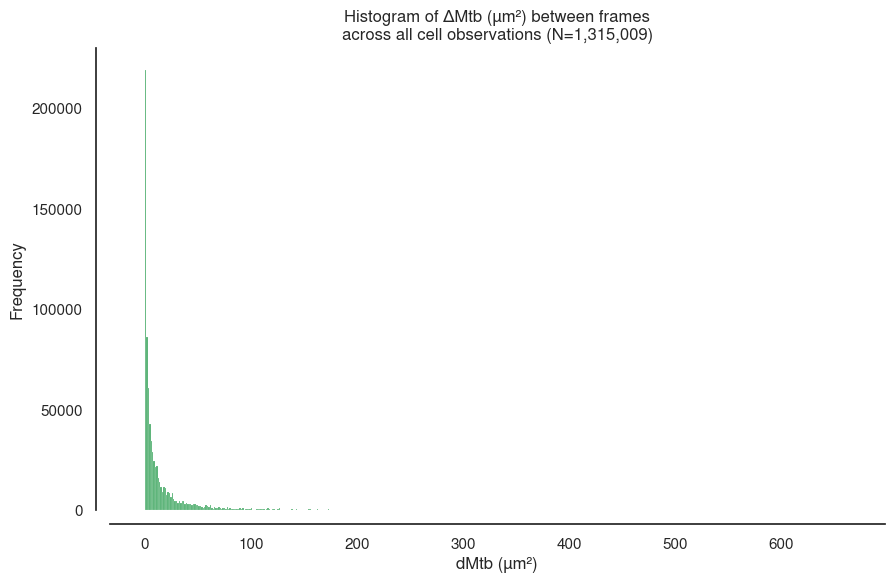

In [320]:
# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['dMtb_p'], bins=500, kde=False)
# plt.xlim(0,150)
# plt.ylim(0, 30000)
# plt.ylim(10E0,10E6)
# plt.yscale('log')
plt.xlabel('dMtb (µm²)')
# plt.vlines(ymin=0, ymax=10E7, x=0, lw = 1, colors=expanded_piyg[-1])
plt.ylabel('Frequency')
title = 'Histogram of ΔMtb (µm²) between frames\nacross all cell observations (N=1,315,009)'
plt.title(title)
filename = title.replace('Δ', 'dMtb').replace('µm²', 'um2').replace('\n', '_').replace(' ', '_').replace('=', '').replace(',', '') + '.pdf'
sns.despine(offset = 10)
plt.savefig(os.path.join(output_dir, filename), dpi = 314, bbox_inches = 'tight')
plt.show()

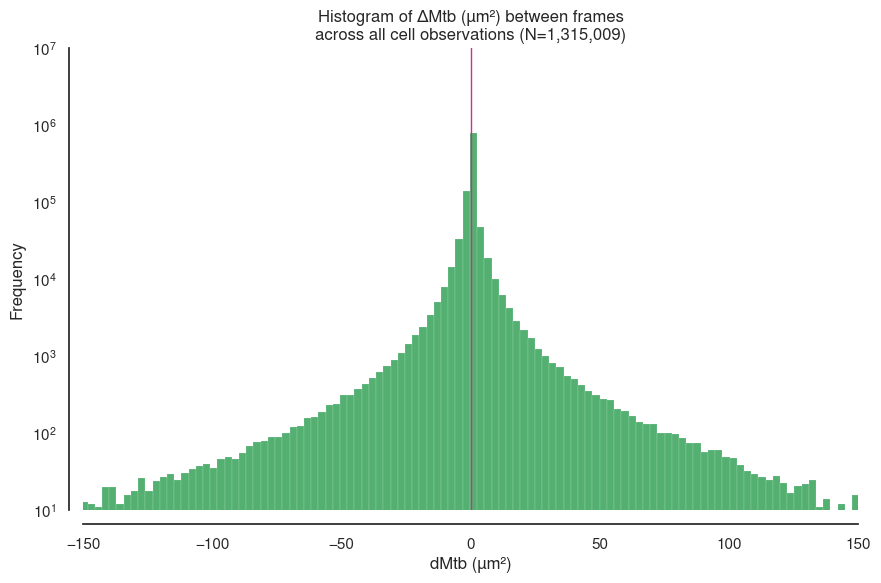

In [46]:
# Drop NaN values before plotting
df_clean = df['dMtb (µm²)'].dropna()

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_clean, bins=500, kde=False)
plt.xlim(-150,150)
plt.ylim(10E0,10E6)
plt.yscale('log')
plt.xlabel('dMtb (µm²)')
plt.vlines(ymin=0, ymax=10E7, x=0, lw = 1, colors=expanded_piyg[-1])
plt.ylabel('Frequency')
title = 'Histogram of ΔMtb (µm²) between frames\nacross all cell observations (N=1,315,009)'
plt.title(title)
filename = title.replace('Δ', 'dMtb').replace('µm²', 'um2').replace('\n', '_').replace(' ', '_').replace('=', '').replace(',', '') + '.pdf'
sns.despine(offset = 10)
plt.savefig(os.path.join(output_dir, filename), dpi = 314, bbox_inches = 'tight')
plt.show()


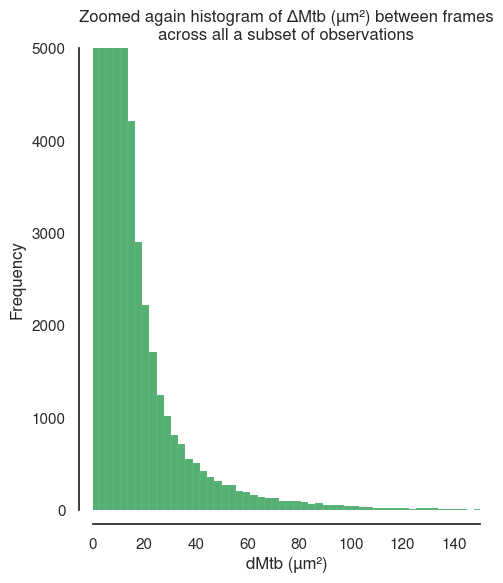

In [60]:
# Drop NaN values before plotting
df_clean = df['dMtb (µm²)'].dropna()

# Plot the histogram
plt.figure(figsize=(5, 6))
sns.histplot(df_clean, bins=500, kde=False)
plt.xlim(0,150)
plt.ylim(0,5000)
# plt.yscale('log')
plt.xlabel('dMtb (µm²)')
# plt.vlines(ymin=0, ymax=10E7, x=0, lw = 1, colors=expanded_piyg[-1])
plt.ylabel('Frequency')
title = 'Zoomed again histogram of ΔMtb (µm²) between frames\nacross all a subset of observations'
plt.title(title)
filename = title.replace('Δ', 'dMtb').replace('µm²', 'um2').replace('\n', '_').replace(' ', '_').replace('=', '').replace(',', '') + '.pdf'
sns.despine(offset = 10)
plt.savefig(os.path.join(output_dir, filename), dpi = 314, bbox_inches = 'tight')
plt.show()

# Using previously manually labelled data to generate a threshold

In [61]:
os.listdir('/mnt/SYNO/macrohet_syno/results/mtb_origin/')

['wt_PZA_EC99_init_uninf_updated_rapid_growers.csv',
 'wt_CTRL_EC0_init_uninf_updated_rapid_growers.csv',
 'wt_RIF_EC50_init_uninf_updated_rapid_growers.csv',
 'wt_PZA_EC50_init_uninf_updated_rapid_growers.csv',
 'wt_INH_EC50_init_uninf_updated_rapid_growers.csv',
 'wt_RIF_EC99_init_uninf_updated_rapid_growers.csv',
 'wt_INH_EC99_init_uninf_updated_rapid_growers.csv',
 'wt_BDQ_EC99_init_uninf_updated_rapid_growers.csv',
 'wt_BDQ_EC50_init_uninf_updated_rapid_growers.csv',
 'arx',
 'wt_CTRL_EC0_init_uninf_updated_rapid_growers-BP.csv',
 'wt_CTRL_init_uninf_updated_rapid_growers.csv',
 '.~lock.wt_CTRL_EC0_init_uninf_updated_rapid_growers-BP.csv#',
 'graphs',
 'mtb_originwt_PZA_EC99_init_uninf_updated_rapid_growers.csv']

In [90]:
# Define the directory containing the CSV files
directory = '/mnt/SYNO/macrohet_syno/results/mtb_origin/'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('rapid_growers.csv')]

# Initialize an empty list to hold the DataFrames
df_list = []

# Loop through the CSV files, read each one, and append to the list
for file in csv_files:
    file_path = os.path.join(directory, file)
    df_ = pd.read_csv(file_path)
    df_list.append(df_)

# Concatenate all DataFrames in the list into a single DataFrame
mtb_origin_df = pd.concat(df_list, ignore_index=True)


In [91]:
mtb_origin_df.keys()

Index(['index', 'Acquisition ID', 'Biological Replicate', 'Cell ID',
       'Compound', 'Concentration', 'Eccentricity', 'Experiment ID',
       'Final Infection Status', 'Frame', 'GFP', 'ID', 'Infection Status',
       'Initial Infection Status', 'MSD', 'Mphi Area (µm)', 'Mtb Area (µm)',
       'RFP', 'Strain', 'T_d', 'Technical Replicate', 'Time (hours)',
       'Unique ID', 'dMphi Area (µm)', 'dMtb Area (µm)', 'dt', 'r2', 'x', 'y',
       'doubling_times', 'dmtb_values', 'Strain/Compound', 'mtb_origin', 'dts',
       'dt_dmtb', 'dmtb', 'dts_0', 'dts_1', 'dts_2', 'dts_3', 'dts_4',
       'dmtb_0', 'dmtb_1', 'dmtb_2', 'dmtb_3', 'dmtb_4', 'dt_0', 'dt_1',
       'dt_2', 'dt_3', 'dt_4', 'dt_5', 'dt_6', 'dmtb_5', 'dmtb_6', 'dt_7',
       'dmtb_7', 'dt_8', 'dmtb_8', 'dt_9', 'dmtb_9', 'dt_10', 'dt_11',
       'dmtb_10', 'dmtb_11', 'Unnamed: 0'],
      dtype='object')

In [92]:
del_cols = ['index', 'dts',
       'dt_dmtb', 'dmtb', 'dts_0', 'dts_1', 'dts_2', 'dts_3', 'dts_4',
       'dmtb_0', 'dmtb_1', 'dmtb_2', 'dmtb_3', 'dmtb_4', 'dt_0', 'dt_1',
       'dt_2', 'dt_3', 'dt_4', 'dt_5', 'dt_6', 'dmtb_5', 'dmtb_6', 'dt_7',
       'dmtb_7', 'dt_8', 'dmtb_8', 'dt_9', 'dmtb_9', 'dt_10', 'dt_11',
       'dmtb_10', 'dmtb_11', 'Unnamed: 0']

# Drop the columns from the DataFrame
mtb_origin_df = mtb_origin_df.drop(columns=del_cols)

In [93]:
mtb_origin_df

,Acquisition ID,Biological Replicate,Cell ID,Compound,Concentration,Eccentricity,Experiment ID,Final Infection Status,Frame,GFP,...,dMphi Area (µm),dMtb Area (µm),dt,r2,x,y,doubling_times,dmtb_values,Strain/Compound,mtb_origin
0,"(5, 6)",1,459,PZA,EC99,0.683020,PS0000,1.0,0.0,1027.559814,...,318.242100,31.623074,2.714286,0.805939,994.226929,118.467117,"[1.0, 0.0, 1.0, 1.0, 3.0, 4.0, 9.0]","[0.23, 0.47, 0.93, 1.87, 3.73, 7.47, 14.93]",PZA,Transfer
1,"(5, 6)",1,477,PZA,EC99,0.543988,PS0000,1.0,0.0,3486.001953,...,175.077852,27.466260,2.000000,0.819036,730.888062,138.558258,"[1.0, 1.0, 2.0, 4.0]","[2.0, 4.01, 8.02, 16.04]",PZA,Junk
2,"(5, 6)",1,478,PZA,EC99,0.618693,PS0000,1.0,0.0,1929.670166,...,673.783783,4.894313,1.600000,0.815552,606.672241,156.211548,"[1.0, 0.0, 1.0, 2.0, 4.0]","[0.1, 0.19, 0.39, 0.77, 1.54]",PZA,Uptake
3,"(5, 6)",1,393,PZA,EC99,0.705599,PS0000,1.0,0.0,2907.330322,...,-181.402467,1.854922,0.200000,1.000000,674.664795,304.226410,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.04, 0.09, 0.18, 0.36, 0.72]",PZA,Uptake
4,"(5, 6)",1,587,PZA,EC99,0.729778,PS0000,1.0,0.0,3962.771729,...,701.540573,0.000000,0.000000,1.000000,401.431915,353.343506,"[-0.0, -0.0]","[-0.31, -0.16]",PZA,Junk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,"(4, 6)",3,2576,PZA,EC99,0.564037,ND0003,1.0,44.0,2352.771240,...,32.070043,43.579501,0.857143,0.935824,587.226929,1122.960449,NaN,NaN,PZA,Unknown
1099,"(4, 6)",3,2753,PZA,EC99,0.819223,ND0003,0.0,48.0,1378.107544,...,-670.163333,0.000000,0.000000,1.000000,841.064148,116.046654,NaN,NaN,PZA,Unknown
1100,"(4, 6)",3,3089,PZA,EC99,0.795602,ND0003,1.0,56.0,708.213379,...,-847.453682,22.415507,2.000000,0.814695,760.596191,606.898499,NaN,NaN,PZA,Unknown
1101,"(4, 6)",3,3179,PZA,EC99,0.662271,ND0003,1.0,58.0,708.409790,...,-303.894387,1.206817,7.000000,0.778933,849.719604,162.963684,NaN,NaN,PZA,Unknown


In [95]:
# Filter the DataFrame for rows where 'mtb_origin' is either 'Transfer' or 'Uptake'
filtered_df = mtb_origin_df[mtb_origin_df['mtb_origin'].isin(['Transfer', 'Uptake'])]

# Select only the 'mtb_origin' and 'ID' columns
filtered_df = filtered_df[['mtb_origin', 'ID']]

In [96]:
filtered_df

,mtb_origin,ID
0,Transfer,459.5.6.PS0000
2,Uptake,478.5.6.PS0000
3,Uptake,393.5.6.PS0000
5,Transfer,520.5.6.PS0000
6,Uptake,142.5.6.PS0000
...,...,...
785,Transfer,1355.3.12.ND0003
786,Uptake,1488.3.12.ND0003
787,Transfer,1474.3.12.ND0003
788,Transfer,1717.3.12.ND0003


In [98]:
df = df.merge(filtered_df[['ID', 'mtb_origin']], on='ID', how='left')


In [110]:
df

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,Concentration,Cell ID,Acquisition ID,Experiment ID,Unique ID,ID,Edge Status,Uptake,dMtb Area between frames (µm),mtb_origin
0,0.0,0.424621,-0.424621,459.082108,-92.746118,False,False,False,457.172943,8.791715,...,EC0,426,"(3, 4)",PS0000,426.3.4,426.3.4.PS0000,True,False,NaN,NaN
1,1.0,0.000000,-0.424621,372.839393,-92.746118,False,False,False,459.138947,6.718642,...,EC0,426,"(3, 4)",PS0000,426.3.4,426.3.4.PS0000,True,False,-0.424621,NaN
2,2.0,0.000000,-0.424621,423.168130,-92.746118,False,False,False,460.555237,10.785886,...,EC0,426,"(3, 4)",PS0000,426.3.4,426.3.4.PS0000,True,False,0.000000,NaN
3,3.0,0.335227,-0.424621,445.561289,-92.746118,False,False,False,455.878815,11.143067,...,EC0,426,"(3, 4)",PS0000,426.3.4,426.3.4.PS0000,True,False,0.335227,NaN
4,4.0,0.000000,-0.424621,487.040034,-92.746118,False,False,False,462.634186,14.050420,...,EC0,426,"(3, 4)",PS0000,426.3.4,426.3.4.PS0000,True,False,-0.335227,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315079,74.5,1.117423,1.095075,752.584461,55.088959,False,False,False,227.093262,130.358139,...,EC99,1874,"(6, 12)",ND0003,1874.6.12,1874.6.12.ND0003,False,False,-0.670454,NaN
1315080,75.0,2.033710,1.095075,616.035357,55.088959,True,False,False,226.622925,130.532120,...,EC99,1874,"(6, 12)",ND0003,1874.6.12,1874.6.12.ND0003,False,False,0.916287,NaN
1315081,75.5,1.430302,1.095075,579.182743,55.088959,False,False,False,225.366608,129.932709,...,EC99,1874,"(6, 12)",ND0003,1874.6.12,1874.6.12.ND0003,False,False,-0.603408,NaN
1315082,76.0,1.989013,1.095075,679.147414,55.088959,True,False,False,226.424683,128.489410,...,EC99,1874,"(6, 12)",ND0003,1874.6.12,1874.6.12.ND0003,False,False,0.558712,NaN


In [102]:
uptake_df = df[df['mtb_origin'] == 'Uptake']
transfer_df = df[df['mtb_origin'] == 'Transfer']

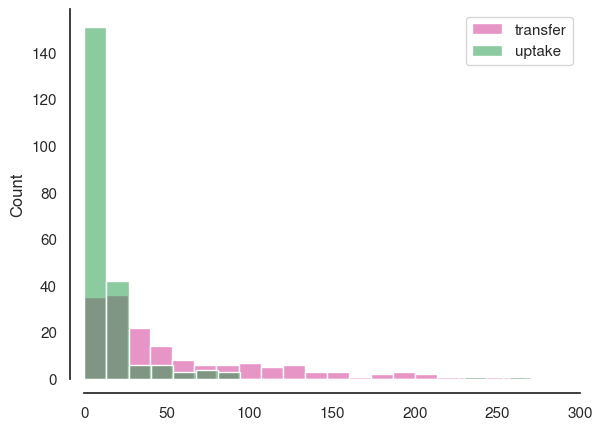

In [113]:
filtered_transfer_df = transfer_df.loc[transfer_df['dMtb Area (µm)'].between(0, 500), 'dMtb Area (µm)'].unique()
filtered_uptake_df = uptake_df.loc[uptake_df['dMtb Area (µm)'].between(0, 500), 'dMtb Area (µm)'].unique()

sns.histplot(filtered_transfer_df, label='transfer', color=expanded_piyg[-1], bins=20, alpha = 0.5)
sns.histplot(filtered_uptake_df, label='uptake', color=expanded_piyg[0], bins=20, alpha = 0.5)
plt.xlim(0, 300)
plt.legend()
sns.despine(offset=10)
plt.show()


In [16]:
# Define a function to check the condition for each ID
def check_uptake_condition(group):
    initial_status = group['Initial Infection Status'].iloc[0:5]
    final_status = group['Final Infection Status'].iloc[-6:-1]
    return initial_status == False and final_status == True

# Identify the IDs that meet the condition
ids_with_uptake = df.groupby('ID').apply(check_uptake_condition)
ids_with_uptake = ids_with_uptake[ids_with_uptake].index

# Create the 'uptake' column and set it to True for the identified IDs
df['Uptake'] = df['ID'].isin(ids_with_uptake)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [137]:
# Create the 'uptake' column and set it to True for the identified IDs
df['Uptake'].value_counts()

False    1134338
True      180671
Name: uptake, dtype: int64

In [141]:
df.to_pickle(os.path.join(base_dir, 'results/dfs/sc_df.pkl'))

# Edit these categories to include others

In [17]:
df['Growth'] = np.nan
df['Reduction'] = np.nan
df['Containment'] = np.nan

for unique_ID in tqdm(df['ID'].unique()):
    sc_dt_df = df[df['ID'] == unique_ID]    
    # create a median rolling window param based on 5 hours (depdendent on time frame of expt)
    window =  5 if 'PS0000' in unique_ID else 10 
    # isolate the time values
    time_points = sc_dt_df['Time (hours)'].values
    # isolate and interpolate the population values to remove NaN values 
    bacterial_population = sc_dt_df['Mtb Area (µm)'].interpolate(method='linear').interpolate(method='backfill').rolling(window=window).median().bfill().values


    # Fit linear regression model
    slope, intercept, r_value, p_value, std_err = stats.linregress(time_points, bacterial_population)

    ### first non zero value TO DO 
    # Determine classification based on the slope
    growth = slope >= 1.92/70
    reduction = slope <= -1.92/70
    containment = -1.92/70 < slope < 1.92/70

    # Update the main DataFrame with the classifications
    df.loc[df['ID'] == unique_ID, 'Growth'] = growth
    df.loc[df['ID'] == unique_ID, 'Reduction'] = reduction
    df.loc[df['ID'] == unique_ID, 'Containment'] = containment

  0%|          | 0/13405 [00:00<?, ?it/s]

In [18]:
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_initial_cats.pkl')

In [5]:
df = pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df.pkl')
# Assuming your DataFrame is named 'df'
df['Strain/Compound'] = df['Compound']  # Create a new column and copy values from 'Compound'
# Replace values in 'NewColumn' where 'Strain' is 'RD1' with 'RD1'
df.loc[df['Strain'] == 'RD1', 'Strain/Compound'] = 'RD1'
df

,index,Acquisition ID,Biological Replicate,Cell ID,Compound,Concentration,Eccentricity,Experiment ID,Final Infection Status,Frame,...,Unique ID,dMphi Area (µm),dMtb Area (µm),dt,r2,x,y,doubling_times,dmtb_values,Strain/Compound
0,0,"(3, 4)",1,426,CTRL,EC0,0.929721,PS0000,0.0,0.0,...,426.3.4,-92.746118,-0.424621,7.0,0.944356,457.172943,8.791715,"[2.0, 3.0, 4.0, 9.0, 17.0]","[0.15, 0.31, 0.62, 1.23, 2.46]",RD1
1,1,"(3, 4)",1,426,CTRL,EC0,0.977788,PS0000,0.0,1.0,...,426.3.4,-92.746118,-0.424621,7.0,0.944356,459.138947,6.718642,"[2.0, 3.0, 4.0, 9.0, 17.0]","[0.15, 0.31, 0.62, 1.23, 2.46]",RD1
2,2,"(3, 4)",1,426,CTRL,EC0,0.733415,PS0000,0.0,2.0,...,426.3.4,-92.746118,-0.424621,7.0,0.944356,460.555237,10.785886,"[2.0, 3.0, 4.0, 9.0, 17.0]","[0.15, 0.31, 0.62, 1.23, 2.46]",RD1
3,3,"(3, 4)",1,426,CTRL,EC0,0.685354,PS0000,0.0,3.0,...,426.3.4,-92.746118,-0.424621,7.0,0.944356,455.878815,11.143067,"[2.0, 3.0, 4.0, 9.0, 17.0]","[0.15, 0.31, 0.62, 1.23, 2.46]",RD1
4,4,"(3, 4)",1,426,CTRL,EC0,0.727210,PS0000,0.0,4.0,...,426.3.4,-92.746118,-0.424621,7.0,0.944356,462.634186,14.050420,"[2.0, 3.0, 4.0, 9.0, 17.0]","[0.15, 0.31, 0.62, 1.23, 2.46]",RD1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315004,1797106,"(6, 12)",3,1874,BDQ,EC99,0.571813,ND0003,1.0,NaN,...,1874.6.12,55.088959,1.095075,NaN,NaN,227.093262,130.358139,[],[],RD1
1315005,1797107,"(6, 12)",3,1874,BDQ,EC99,0.373264,ND0003,1.0,NaN,...,1874.6.12,55.088959,1.095075,NaN,NaN,226.622925,130.532120,[],[],RD1
1315006,1797108,"(6, 12)",3,1874,BDQ,EC99,0.490623,ND0003,1.0,NaN,...,1874.6.12,55.088959,1.095075,NaN,NaN,225.366608,129.932709,[],[],RD1
1315007,1797109,"(6, 12)",3,1874,BDQ,EC99,0.693277,ND0003,1.0,NaN,...,1874.6.12,55.088959,1.095075,NaN,NaN,226.424683,128.489410,[],[],RD1
